In [2]:
import gym
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import random
from collections import deque
import os
import matplotlib.pyplot as plt
import seaborn as sns

## Background Research

- The inverted pendulum swingup problem is based on the classic problem in control theory. 
- The system consists of a pendulum attached at one end to a fixed point, and the other end being free. 
- The pendulum starts in a random position and the goal is to apply torque on the free end to swing it into an upright position, with its center of gravity right above the fixed point.

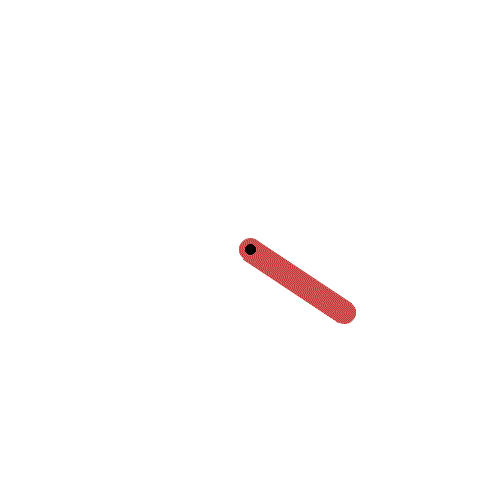

In [35]:
env = gym.make('Pendulum-v0')
print(f"Observation Space representing the x-y coordinates of the pendulum's free end and its angular velocity.{env.observation_space}")
print(f"Action Space Allowed Torque Values : {env.action_space}")
print(f"Reward Range (-16.27, 0)")


Observation Space representing the x-y coordinates of the pendulum's free end and its angular velocity.Box(-8.0, 8.0, (3,), float32)
Action Space Allowed Torque Values : Box(-2.0, 2.0, (1,), float32)
Reward Range (-16.27, 0)


## Build Model

Instantiate DQN Class with preset hyperparameters

In [3]:
np.random.seed(42)
class DQN:
    def __init__(self,
                 InputShape = 3,
                 NActions = 40,
                 Gamma = 0.97,
                 MemorySize = 10000,
                 MinMemory = 1000,
                 UpdateTargetEveryThisEpisodes = 2,
                 Dense_no = 64,
                 BatchSize = 32,
                 Epsilon = 0.1,
                 Epsilon_Decay = 0.95,
                 learning_rate = 0.001,
                 load_weights = False,
                 high_penalty = 0.95,
                 low_penalty = 1.25,
                 low_score_epsilon = 0.1
                 ):
        
        # Preset. #
        self.InputShape = InputShape

        # Hyperparameters. # (Tuneable)
        self.NActions = NActions # Number of Discretized Actions.
        self.Gamma = Gamma # Discount Factor
        self.MemorySize = MemorySize # Max Memory Size
        self.MinMemory = MinMemory # Min Memory Size before Training.
        self.UpdateTargetEveryThisEpisodes = UpdateTargetEveryThisEpisodes # Frequency of Target Update.
        self.Dense_no = Dense_no # Dense Layers
        self.BatchSize = BatchSize # Batch Size for Training.
        self.learning_rate = learning_rate
        self.high_learning_rate_penalty = high_penalty
        self.low_learning_rate_penalty = low_penalty
        self.low_score_epsilon = low_score_epsilon
        # Optimiser. #
        if learning_rate == None:
            self.Optimiser = Adam()
        else: 
            self.Optimiser = Adam(learning_rate=learning_rate) # Optimiser for Training.

        self.Epsilon = Epsilon # Exploration Rate.
        self.Epsilon_Decay = Epsilon_Decay # Exploration Decay Rate.

        print(f""" 
List of Parameters:
Number of Actions: {self.NActions},
Gamma: {self.Gamma},
Learning Rate: {self.learning_rate},
Memory Size: {self.MemorySize},
Min Memory: {self.MinMemory},
Update Target Every This Episodes: {self.UpdateTargetEveryThisEpisodes},
Dense Layers: {self.Dense_no},
Batch Size: {self.BatchSize},
Epsilon: {self.Epsilon},
Epsilon Decay: {self.Epsilon_Decay},
Optimiser: {self.Optimiser.learning_rate.numpy()},
High Penalty: {self.high_learning_rate_penalty},
Low Penalty: {self.low_learning_rate_penalty},
Low Score Epsilon: {self.low_score_epsilon}
""")
        

        # Main Model. #
        self.Main = self.Model('Main')
        if load_weights != False:
            self.Main.load_weights(load_weights)
        # Target Model. #
        self.T = self.Model('Target')
        self.update_t_weights()
        self.Memory = deque(maxlen = MemorySize)
        self.TargetUpdateCounter = 0
    
    # Create Model. #
    def Model(self, Type):

        inputs = Input(shape = (self.InputShape), name = 'Input')
        x = Dense(self.Dense_no, activation = 'relu', name = '1stHiddenLayer')(inputs)
        x = Dense(self.Dense_no, activation = 'relu', name = '2ndHiddenLayer')(x)
        outputs = Dense(self.NActions, activation = 'linear', name = 'Output')(x)
        NN = Model(inputs, outputs, name = f'{Type}')
        NN.summary()
        
        return NN
    
    def UpdateMemory(self, Information): # Update Memory.
        self.Memory.append(Information)

    def update_t_weights(self): # Update Target Model.
        self.T.set_weights(self.Main.get_weights())

    def PendulumActionConverter(self, A): # Discritize Action.
        ActualTorque = (A / self.NActions - 0.5) * 4 # Normalise to [-2, 2] 
        return ActualTorque

    def PendulumInverseActionConverter(self, A): # Undiscritize Action.
        ActualA = round((A + 2) * (self.NActions - 1) / 4)
        return(ActualA)
    
    def adjust_learning_rate_and_epsilon(self, score):
        # Define thresholds for score
        high_score_threshold = -300
        low_score_threshold = -800

        # Define learning rate and epsilon adjustment factors
        high_score_learning_rate_factor = 0.95
        low_score_learning_rate_factor = self.low_learning_rate_penalty

        mid_score_learning_rate_factor = 0.99
        mid_score_epsilon_decay = 0.99
        
        high_score_epsilon_decay = self.Epsilon_Decay
        low_score_epsilon_increase = self.low_score_epsilon

        # Adjust learning rate and epsilon based on score
        if score >= high_score_threshold:
            # If score is high, decrease learning rate and epsilon
            self.learning_rate *= high_score_learning_rate_factor
            self.Epsilon *= high_score_epsilon_decay
        
        if low_score_threshold < score < high_score_threshold:
            # If score is in between, decrease learning rate and epsilon
            self.learning_rate *= mid_score_learning_rate_factor
            self.Epsilon *=  mid_score_epsilon_decay

        elif score < low_score_threshold:
            # If score is low, increase learning rate and epsilon
            self.learning_rate *= low_score_learning_rate_factor
            self.Epsilon += low_score_epsilon_increase
            if self.Epsilon == 0.4:
                self.Epsilon = 0.1

        # Ensure learning rate and epsilon are within reasonable bounds
        self.learning_rate = min(max(self.learning_rate, 0.0001), 0.4)
        self.Epsilon = min(max(self.Epsilon, 0.001), 0.4)

        # Update optimizer with new learning rate
        self.Optimiser = Adam(learning_rate=self.learning_rate)

        
    def GetAction(self, env, Q): # Getting Action from Q Values.
        if np.random.rand() <= self.Epsilon:
            AStep = env.action_space.sample()
            A = self.PendulumInverseActionConverter(AStep[0])
        else:
            A = np.argmax(Q)
            A = self.PendulumActionConverter(A)
            AStep = np.array([A])
            A = self.PendulumInverseActionConverter(A)
        return A, AStep
    
    def save_weights(self, path):
        if path == None:
            return
        self.Main.save_weights('DQN_Weights/'+'Main'+path)
        self.T.save_weights('DQN_Weights/' + 'Target'+path)

    def Train(self, EndOfEpisode, Normalization = False): # Training.
        if len(self.Memory) < self.MinMemory:
            return

        TrainingData = random.sample(self.Memory, self.BatchSize)
        
        ListOfS = np.array([element[0] for element in TrainingData])
        ListOfQ = np.array(self.Main(ListOfS)) # Q Values for Current State

        ListOfSNext = np.array([element[3] for element in TrainingData])
        ListOfQNext = self.T(ListOfSNext) # Q Values for Next State.
        

        X = []
        Y = []
        for index, (S, A, R, SNext, Done) in enumerate(TrainingData): 
            if not Done:

                MaxQNext = np.max(ListOfQNext[index]) # Target Q Value for Next State.
                QNext = R + self.Gamma * MaxQNext # Sum of the reward and the discounted maximum Q-value

            else:
                QNext = R # If the episode is done, the Q-value is just the reward.

            Q = ListOfQ[index] 
            Q[A] = QNext  # Q-value for the chosen action (A) in the current state is updated to the target 

            X.append(S) # States
            Y.append(Q) # Q Values
        self.GTfit(X, Y)
                
        if EndOfEpisode:
            self.TargetUpdateCounter += 1

        if self.TargetUpdateCounter >= self.UpdateTargetEveryThisEpisodes:
            self.update_t_weights()
            self.TargetUpdateCounter = 0
        
    @tf.function
    def GTfit(self, X, Y): # Gradient Tape Fit.
        with tf.GradientTape() as tape:
            Predictions = self.Main(tf.convert_to_tensor(X), training = True)
            Loss = tf.math.reduce_mean(tf.math.square(tf.convert_to_tensor(Y) - Predictions))
        Grad = tape.gradient(Loss, self.Main.trainable_variables)
        self.Optimiser.apply_gradients(zip(Grad, self.Main.trainable_variables))



Define the Run() Function to allow for easier tuning and run of the model

In [24]:
def OneEpisode(dqn, _, Normalization = False, replay_memory = False):
    env = gym.make('Pendulum-v0')
    env.seed(43)
    S = env.reset()
    score = 0
    Done = False
    while not Done:
        Q = dqn.Main(S.reshape(-1, S.shape[0]))
        A, AStep = dqn.GetAction(env, Q)
        if not _ % 10 and len(dqn.Memory) >= dqn.MinMemory:
            env.render()
        
        SNext, R, Done, Info = env.step(AStep)
        if replay_memory==True:
            dqn.UpdateMemory((S, A, R, SNext, Done))
        dqn.Train(Done, Normalization)
        score += R
        if Done:
            dqn.adjust_learning_rate_and_epsilon(score)
            env.close()
            return score
        S = SNext

def RunEpisodes(dqn, episodes, Normalize = False, save_weights = 'BaseWeights.h5', load_weights = False, replay_memory = False):
    import time
    STARTTIME = time.time()
    score = []
    ma = []
    for _ in range(episodes):
        s = OneEpisode(dqn, _, Normalize, replay_memory)
        score.append(s)
        moving_average = np.mean(score[-100:])
        ma.append(moving_average)
        if load_weights == False:
            if s == max(score):
                dqn.save_weights(f'Pendulum_{save_weights}')
        print(f'Episode {_}, Score : {s}, Moving Average : {moving_average}, Epsilon : {dqn.Epsilon}, learning rate : {dqn.learning_rate}')
        
    print(f'Total time taken: {time.time() - STARTTIME} seconds ...')
    return score, ma

## Base Model & Results

In [3]:
EPISODES = 300
episode_number = np.arange(EPISODES)

In [6]:
dqn = DQN(InputShape = 3)
base_scores, base_average = RunEpisodes(dqn, EPISODES)

 
List of Parameters:
Number of Actions: 40,
Gamma: 0.97,
Learning Rate: 0.001,
Memory Size: 10000,
Min Memory: 1000,
Update Target Every This Episodes: 2,
Dense Layers: 64,
Batch Size: 32,
Epsilon: 0.1,
Epsilon Decay: 0.95,
Optimiser: 0.0010000000474974513,
High Penalty: 0.95,
Low Penalty: 1.25,
Low Score Epsilon: 0.1

Model: "Main"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 3)]               0         
                                                                 
 1stHiddenLayer (Dense)      (None, 64)                256       
                                                                 
 2ndHiddenLayer (Dense)      (None, 64)                4160      
                                                                 
 Output (Dense)              (None, 40)                2600      
                                                                 
Tota

In [ ]:
plt.figure(figsize=(10, 8))

sns.lineplot(x=episode_number, y=base_scores, label="Score")
sns.lineplot(x=episode_number, y=base_average, label="Average Score")
plt.title('Base Model Performance')

plt.tight_layout()
plt.show()


## Tune Model
Variables to Tune
1. NAction
2. Gamma (Discount Factor)
3. High-Score Learning Rate Adjustment
4. Normalize 
5. Epsilon Decay

For the first 2, I loaded in the model weights to ensure that the model learnt correctly

In [26]:
## Variables
NActions = [40, 50, 60, 70]
Gamma = [1, 0.99, 0.98, 0.97]
Low_Score_Adjust_Learning_Rate = [1.1,1.25, 1.3, 1.4]
Low_Score_Epsilon_Increase = [0.001, 0.005, 0.1, 0.15]
MemorySize = [5000, 10000, 20000]
Update_Target = [1, 2, 3, 4]

# In the other .ipynb file
Normalize = [True, False]

### NActions
Tune the number of discretized actions. The more actions, the more precise the model can be but it's more volatile

In [10]:
NActions_Score = []
NActions_Average = []
for i in NActions:
    dqn = DQN(InputShape = 3, NActions = i)
    scores, average = RunEpisodes(dqn, EPISODES, save_weights=f'NActions_{i}.h5')
    NActions_Score.append(scores)
    NActions_Average.append(average)

 
List of Parameters:
Number of Actions: 40,
Gamma: 0.97,
Memory Size: 10000,
Min Memory: 1000,
Update Target Every This Episodes: 2,
Dense Layers: 64,
Batch Size: 32,
Epsilon: 0.1,
Epsilon Decay: 0.95,
Optimiser: 0.0010000000474974513,

Model: "Main"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 3)]               0         
                                                                 
 1stHiddenLayer (Dense)      (None, 64)                256       
                                                                 
 2ndHiddenLayer (Dense)      (None, 64)                4160      
                                                                 
 Output (Dense)              (None, 40)                2600      
                                                                 
Total params: 7016 (27.41 KB)
Trainable params: 7016 (27.41 KB)
Non-trainable params: 0 

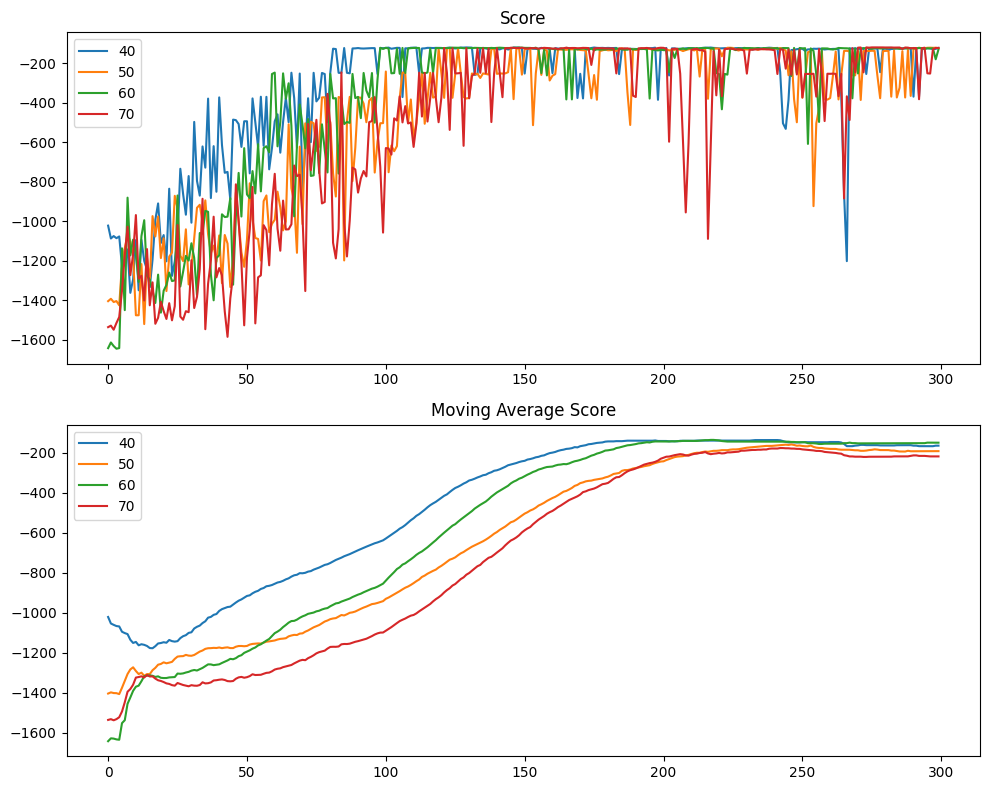

In [11]:
plt.figure(figsize=(10, 8))

plt.subplot(2,1,1)
for i in range(len(NActions)):
    sns.lineplot(x=episode_number, y=NActions_Score[i], label=NActions[i])
plt.title('Score')  

# Moving Average Score
plt.subplot(2, 1, 2)
for i in range (len(NActions)):
    sns.lineplot(x=episode_number, y=NActions_Average[i], label=NActions[i])
plt.title('Moving Average Score')

plt.tight_layout()
plt.show()

In [16]:
weights = ['DQN_Weights/MainPendulum_NActions_40.h5', 'DQN_Weights/MainPendulum_NActions_50.h5', 'DQN_Weights/MainPendulum_NActions_60.h5', 'DQN_Weights/MainPendulum_NActions_70.h5']

scores_NActions = []
average_NActions = []
for i in range(len(weights)):
    dqn = DQN(InputShape = 3, load_weights = weights[i], NActions = NActions[i])
    scores, average = RunEpisodes(dqn, 30, save_weights=None)
    scores_NActions.append(scores)
    average_NActions.append(average)


 
List of Parameters:
Number of Actions: 40,
Gamma: 0.97,
Memory Size: 10000,
Min Memory: 1000,
Update Target Every This Episodes: 2,
Dense Layers: 64,
Batch Size: 32,
Epsilon: 0.1,
Epsilon Decay: 0.95,
Optimiser: 0.0010000000474974513,

Model: "Main"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 3)]               0         
                                                                 
 1stHiddenLayer (Dense)      (None, 64)                256       
                                                                 
 2ndHiddenLayer (Dense)      (None, 64)                4160      
                                                                 
 Output (Dense)              (None, 40)                2600      
                                                                 
Total params: 7016 (27.41 KB)
Trainable params: 7016 (27.41 KB)
Non-trainable params: 0 

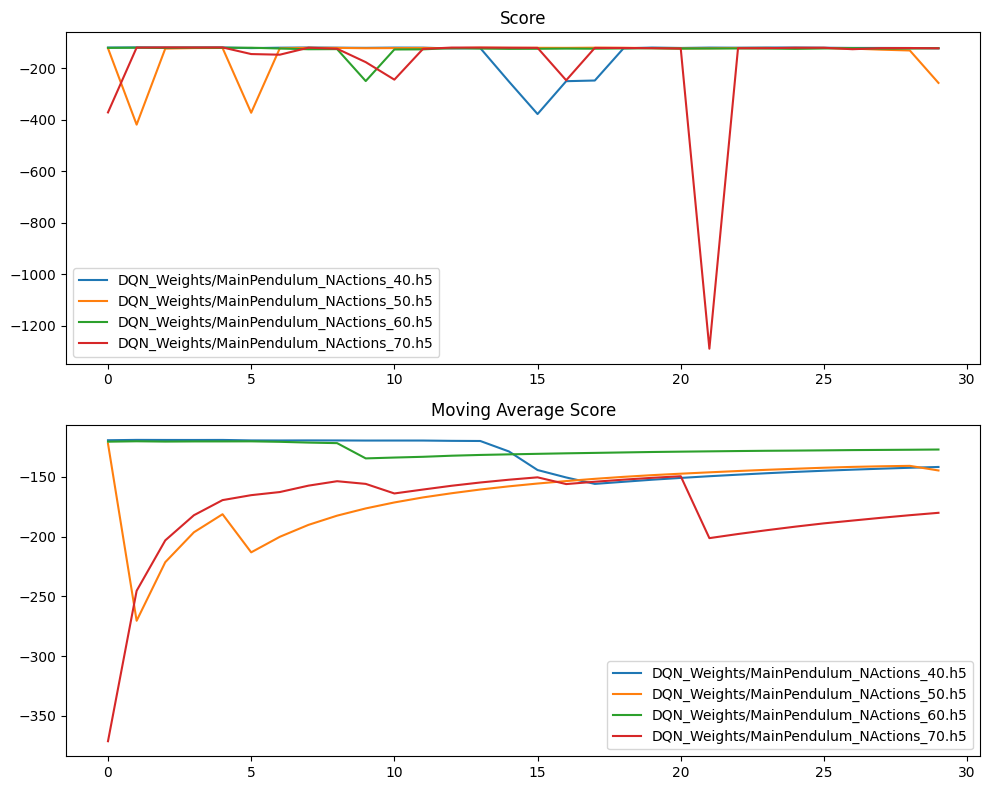

In [17]:
plt.figure(figsize=(10, 8))

plt.subplot(2,1,1)
s = np.arange(30)
for i in range(len(NActions)):
    sns.lineplot(x=s, y=scores_NActions[i], label=weights[i])
plt.title('Score')  

# Moving Average Score
plt.subplot(2, 1, 2)
for i in range (len(NActions)):
    sns.lineplot(x=s, y=average_NActions[i], label=weights[i])
plt.title('Moving Average Score')

plt.tight_layout()
plt.show()

The most stable, and the one to converge the quickest is at 40bins, this sugggest that 70actions is too many and the model wasn't able to converge as quickly

### Gamma (Discount Factor)

The amount of importance given to the future states

Formula for calculating QNext = R + Discount Reward * MaxQNext

In [18]:
Gamma_scores = []
Gamma_average = []
for i in Gamma:
    dqn = DQN(InputShape = 3, NActions = 40, Gamma = i)
    scores, average = RunEpisodes(dqn, EPISODES, save_weights=f'test/Gamma_{i}.h5')
    Gamma_scores.append(scores)
    Gamma_average.append(average)

 
List of Parameters:
Number of Actions: 40,
Gamma: 1,
Memory Size: 10000,
Min Memory: 1000,
Update Target Every This Episodes: 2,
Dense Layers: 64,
Batch Size: 32,
Epsilon: 0.1,
Epsilon Decay: 0.95,
Optimiser: 0.0010000000474974513,

Model: "Main"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 3)]               0         
                                                                 
 1stHiddenLayer (Dense)      (None, 64)                256       
                                                                 
 2ndHiddenLayer (Dense)      (None, 64)                4160      
                                                                 
 Output (Dense)              (None, 40)                2600      
                                                                 
Total params: 7016 (27.41 KB)
Trainable params: 7016 (27.41 KB)
Non-trainable params: 0 (0.

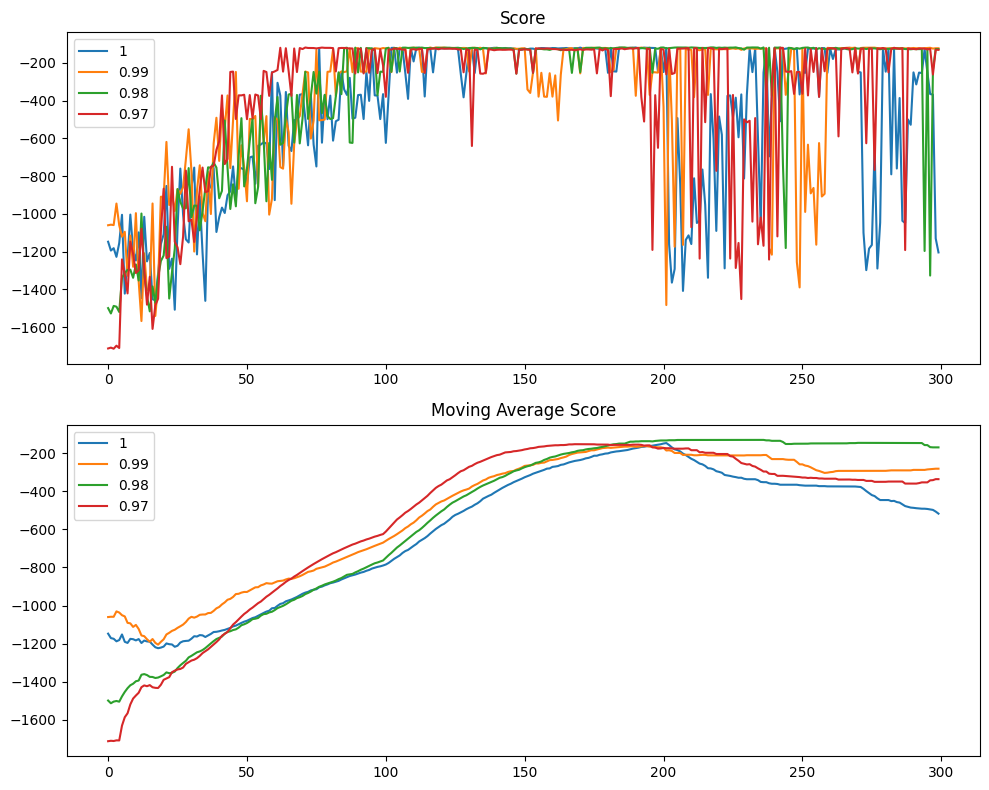

In [19]:
plt.figure(figsize=(10, 8))

plt.subplot(2,1,1)
for i in range(len(Gamma)):
    sns.lineplot(x=episode_number, y=Gamma_scores[i], label=Gamma[i])
plt.title('Score')  

# Moving Average Score
plt.subplot(2, 1, 2)
for i in range (len(Gamma)):
    sns.lineplot(x=episode_number, y=Gamma_average[i], label=Gamma[i])
plt.title('Moving Average Score')

plt.tight_layout()
plt.show()

From the inspection of the graph we observe, that 0.98 is the best value for gamma, this balance between current and future rewards is the most optimal

Load in from Weights to test if the model has learnt correctly

In [31]:
weights_Gamma = ['DQN_Weights/MainPendulum_Gamma_1.h5', 'DQN_Weights/MainPendulum_Gamma_0.99.h5', 'DQN_Weights/MainPendulum_Gamma_0.98.h5', 'DQN_Weights/MainPendulum_Gamma_0.97.h5']
weights_gamma_score = []
weights_gamma_average = []
for i in range(len(weights_Gamma)):
    dqn = DQN(InputShape = 3, load_weights = weights_Gamma[i], NActions = 40, Gamma = Gamma[i])
    scores, average = RunEpisodes(dqn, 30, save_weights=False, load_weights=True)
    weights_gamma_score.append(scores)
    weights_gamma_average.append(average)

 
List of Parameters:
Number of Actions: 40,
Gamma: 1,
Memory Size: 10000,
Min Memory: 1000,
Update Target Every This Episodes: 2,
Dense Layers: 64,
Batch Size: 32,
Epsilon: 0.1,
Epsilon Decay: 0.95,
Optimiser: 0.0010000000474974513,

Model: "Main"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 3)]               0         
                                                                 
 1stHiddenLayer (Dense)      (None, 64)                256       
                                                                 
 2ndHiddenLayer (Dense)      (None, 64)                4160      
                                                                 
 Output (Dense)              (None, 40)                2600      
                                                                 
Total params: 7016 (27.41 KB)
Trainable params: 7016 (27.41 KB)
Non-trainable params: 0 (0.

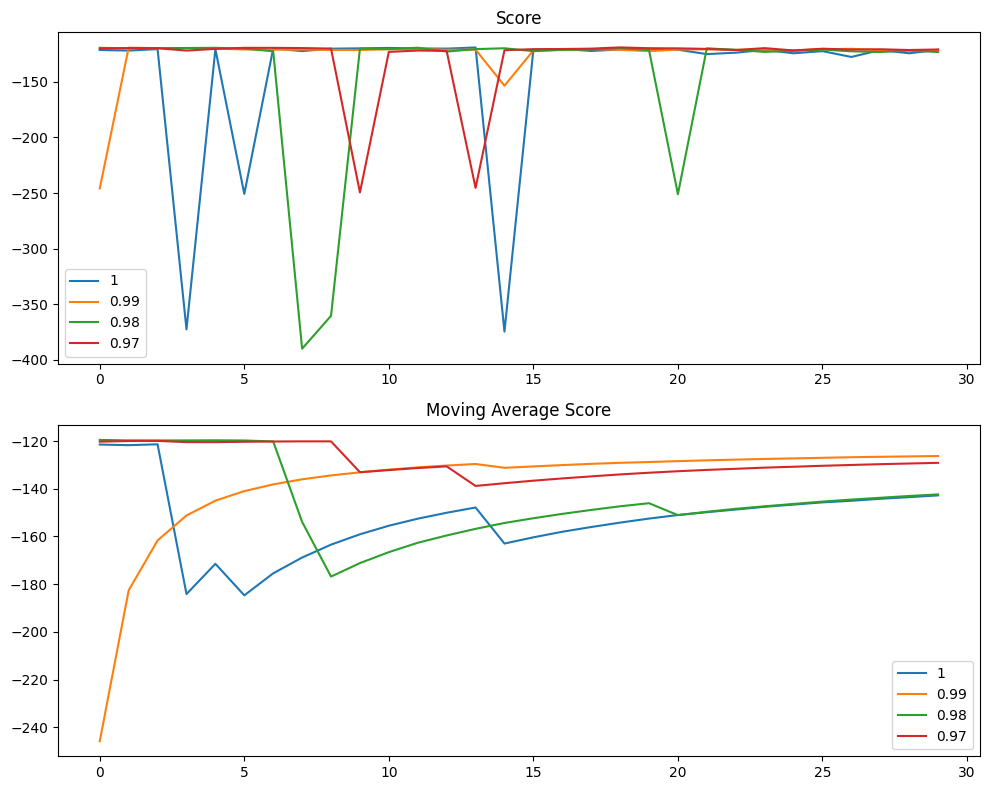

In [33]:
plt.figure(figsize=(10, 8))

plt.subplot(2,1,1)
for i in range(len(Gamma)):
    sns.lineplot(x=s, y=weights_gamma_score[i], label=Gamma[i])
plt.title('Score')  

# Moving Average Score
plt.subplot(2, 1, 2)
for i in range (len(Gamma)):
    sns.lineplot(x=s, y=weights_gamma_average[i], label=Gamma[i])
plt.title('Moving Average Score')

plt.tight_layout()

### Penalized Learning Rate for High Score
How much the learning rate increases/episode if the score is less than -800
By doing this we adjust the learning rate so the model converges faster and with more stability

In [12]:
Low_Score_Adjust_Learning_Rate_Score = []
Low_Score_Adjust_Learning_Rate_Average = []
for i in Low_Score_Adjust_Learning_Rate:
    dqn = DQN(InputShape = 3, NActions = 40, Gamma = 0.98, low_penalty=i)
    scores, average = RunEpisodes(dqn, EPISODES, save_weights=f'Low_Score_Adjust_Learning_Rate_{i}.h5', load_weights=False)
    Low_Score_Adjust_Learning_Rate_Score.append(scores)
    Low_Score_Adjust_Learning_Rate_Average.append(average)

 
List of Parameters:
Number of Actions: 40,
Gamma: 0.98,
Learning Rate: 0.001,
Memory Size: 10000,
Min Memory: 1000,
Update Target Every This Episodes: 2,
Dense Layers: 64,
Batch Size: 32,
Epsilon: 0.1,
Epsilon Decay: 0.95,
Optimiser: 0.0010000000474974513,
High Penalty: 0.95,
Low Penalty: 1.1

Model: "Main"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 3)]               0         
                                                                 
 1stHiddenLayer (Dense)      (None, 64)                256       
                                                                 
 2ndHiddenLayer (Dense)      (None, 64)                4160      
                                                                 
 Output (Dense)              (None, 40)                2600      
                                                                 
Total params: 7016 (27.41 KB)

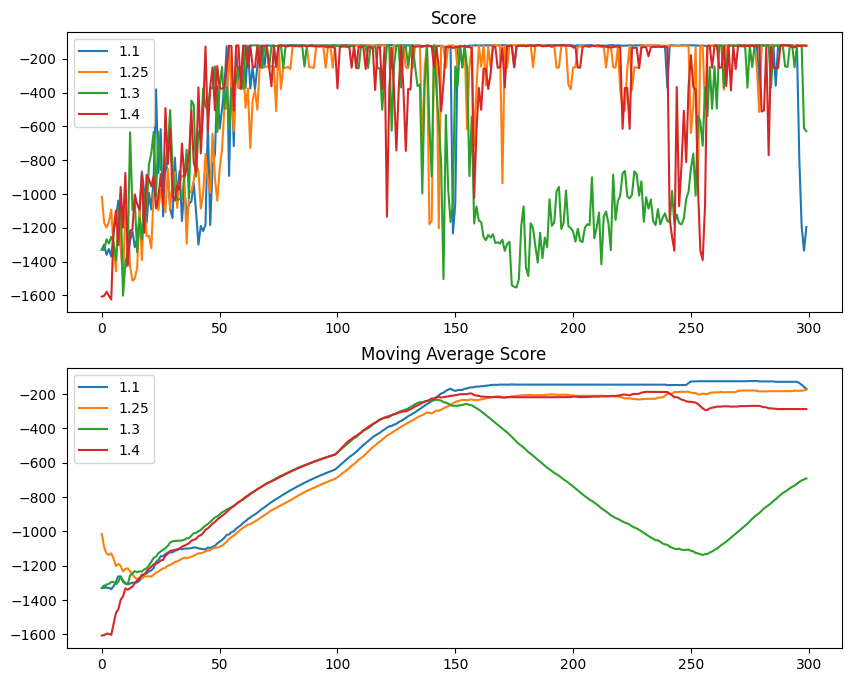

In [14]:
plt.figure(figsize=(10, 8))

plt.subplot(2,1,1)
for i in range(len(Low_Score_Adjust_Learning_Rate)):
    sns.lineplot(x=episode_number, y=Low_Score_Adjust_Learning_Rate_Score[i], label=Low_Score_Adjust_Learning_Rate[i])
plt.title('Score')  

# Moving Average Score
plt.subplot(2, 1, 2)
for i in range (len(Low_Score_Adjust_Learning_Rate)):
    sns.lineplot(x=episode_number, y=Low_Score_Adjust_Learning_Rate_Average[i], label=Low_Score_Adjust_Learning_Rate[i])
plt.title('Moving Average Score')

# plt.tight_layout()
plt.show()

Observations:
- 1.3's model had crashed, but was able to re-learn in about 100 episodes
- 1.4 converged the quickest, but it has the most amount of dips in performance

-The best and most stable is 1.1, it converged slighly slower than the other learning rate's but was mroe stable once the model has converged to the local optimum



### Low Score Epsilon Increase

If the score is less than -800, how much does my epsilon increase by, slowly manages, balances how much the model exploits and explores

In [24]:
Low_Score_Epsilon_Increase_Score = []
Low_Score_Epsilon_Increase_Average = []
for i in Low_Score_Epsilon_Increase:
    dqn = DQN(InputShape = 3, NActions = 40, Gamma = 0.98, low_penalty= 1.1, low_score_epsilon=i)
    scores, average = RunEpisodes(dqn, EPISODES, save_weights=f'Low_Score_Epsilon_Increase_{i}.h5', load_weights=False)
    Low_Score_Epsilon_Increase_Score.append(scores)
    Low_Score_Epsilon_Increase_Average.append(average)

 
List of Parameters:
Number of Actions: 40,
Gamma: 0.98,
Learning Rate: 0.001,
Memory Size: 10000,
Min Memory: 1000,
Update Target Every This Episodes: 2,
Dense Layers: 64,
Batch Size: 32,
Epsilon: 0.1,
Epsilon Decay: 0.95,
Optimiser: 0.0010000000474974513,
High Penalty: 0.95,
Low Penalty: 1.1,
Low Score Epsilon: 0.001

Model: "Main"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 3)]               0         
                                                                 
 1stHiddenLayer (Dense)      (None, 64)                256       
                                                                 
 2ndHiddenLayer (Dense)      (None, 64)                4160      
                                                                 
 Output (Dense)              (None, 40)                2600      
                                                                 
Tot

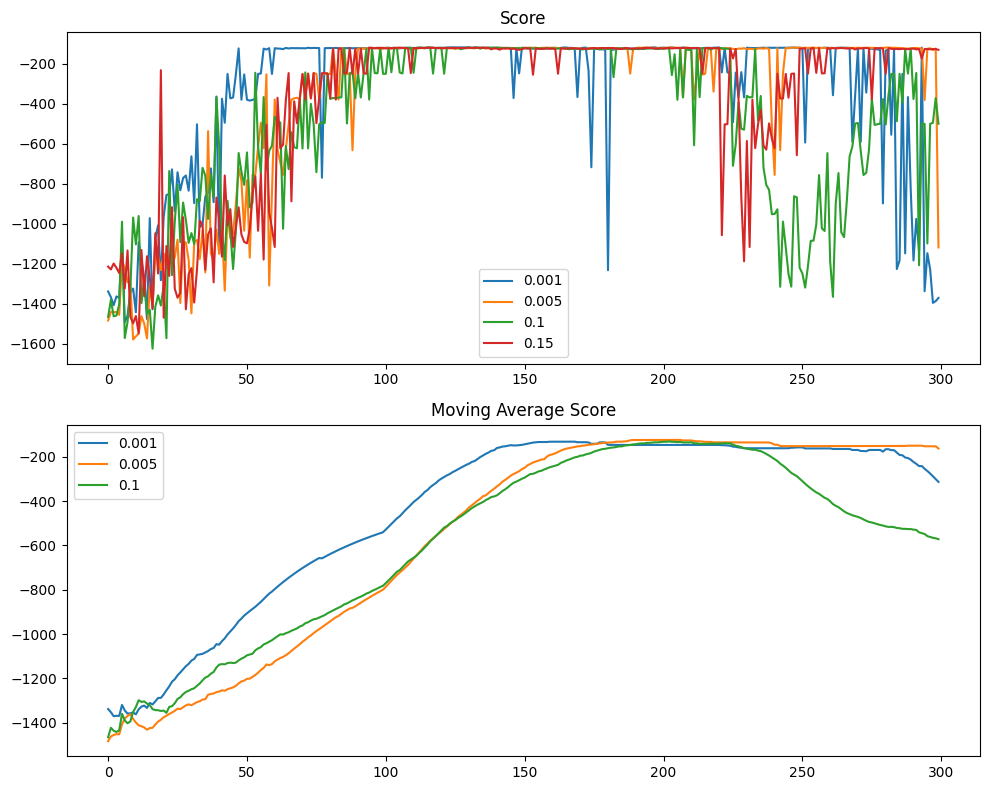

In [25]:
plt.figure(figsize=(10, 8))

plt.subplot(2,1,1)
for i in range(len(Low_Score_Epsilon_Increase)):
    sns.lineplot(x=episode_number, y=Low_Score_Epsilon_Increase_Score[i], label=Low_Score_Epsilon_Increase[i])
plt.title('Score')  

# Moving Average Score
plt.subplot(2, 1, 2)
for i in range (len(Epsilon_Decay)):
    sns.lineplot(x=episode_number, y=Low_Score_Epsilon_Increase_Average[i], label=Low_Score_Epsilon_Increase[i])
plt.title('Moving Average Score')

plt.tight_layout()
plt.show()

I found that 0.005 which is the miground in between my 2 other values. Was the best value, it allowed my model to explore and exploit enough that it converged the fastest and was stable later on as well

### Memory Length

Memory Length, determines how many steps of past experience the agent remembers and allows them to make better decisions.
Longer memory length can help if the past experiences provide valuable decisions for making decisions
However, it comes with computational cost and complexity

In [27]:
memory_size_scores = []
memory_size_average = []

for i in MemorySize:
    dqn = DQN(InputShape = 3, NActions = 40, Gamma = 0.98, low_penalty= 1.1, low_score_epsilon=0.005, MemorySize=i)
    scores, average = RunEpisodes(dqn, EPISODES, save_weights=f'MemorySize_{i}.h5', load_weights=False)
    memory_size_scores.append(scores)
    memory_size_average.append(average)

 
List of Parameters:
Number of Actions: 40,
Gamma: 0.98,
Learning Rate: 0.001,
Memory Size: 5000,
Min Memory: 1000,
Update Target Every This Episodes: 2,
Dense Layers: 64,
Batch Size: 32,
Epsilon: 0.1,
Epsilon Decay: 0.95,
Optimiser: 0.0010000000474974513,
High Penalty: 0.95,
Low Penalty: 1.1,
Low Score Epsilon: 0.005

Model: "Main"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 3)]               0         
                                                                 
 1stHiddenLayer (Dense)      (None, 64)                256       
                                                                 
 2ndHiddenLayer (Dense)      (None, 64)                4160      
                                                                 
 Output (Dense)              (None, 40)                2600      
                                                                 
Tota

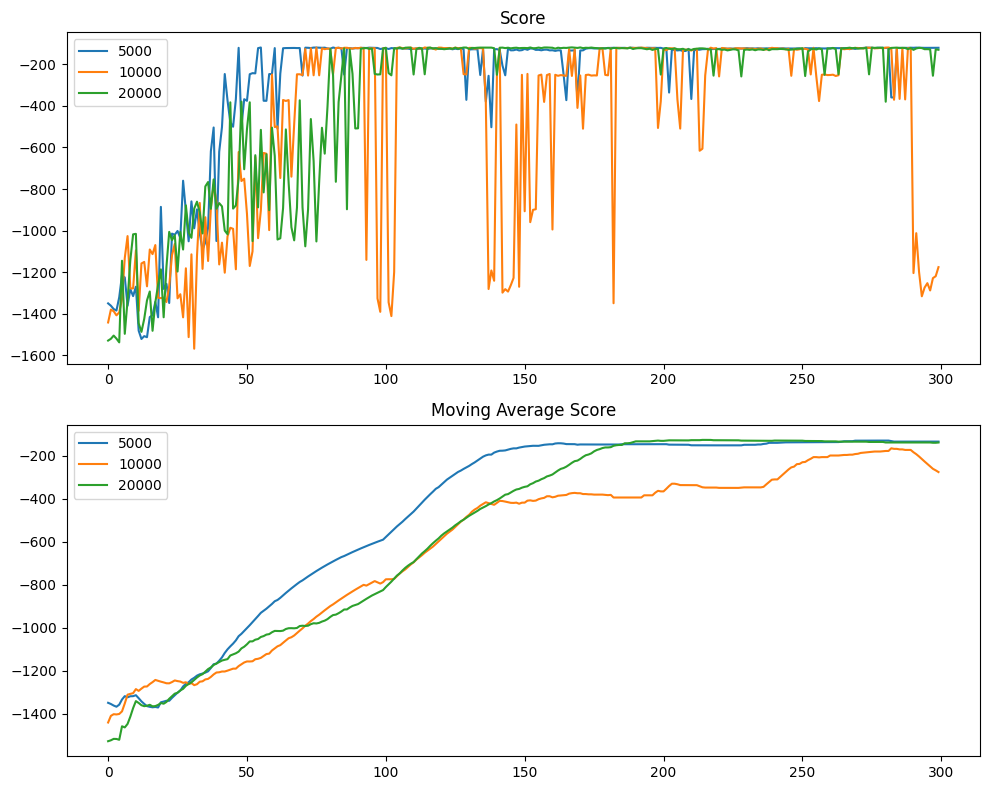

In [28]:
plt.figure(figsize=(10, 8))

plt.subplot(2,1,1)
for i in range(len(MemorySize)):
    sns.lineplot(x=episode_number, y=memory_size_scores[i], label=MemorySize[i])
plt.title('Score')  

# Moving Average Score
plt.subplot(2, 1, 2)
for i in range (len(MemorySize)):
    sns.lineplot(x=episode_number, y=memory_size_average[i], label=MemorySize[i])
plt.title('Moving Average Score')

plt.tight_layout()
plt.show()

From observation it can be said that 5000 was the best memory length. However, trying to recreate the results with a MemorySize of 5000, it appears that this train was just by luck. On the other hand, 20,000 was very consistent and I was able to re-create similar if not better results than the one above

### Update Target

In [29]:
Update_Target_scores = []
Update_Target_average = []
for i in Update_Target:
    dqn = DQN(InputShape = 3, NActions = 40, Gamma = 0.98, low_penalty= 1.1, low_score_epsilon=0.005, MemorySize=20000, UpdateTargetEveryThisEpisodes=i)
    scores, average = RunEpisodes(dqn, EPISODES, save_weights=f'Update_Target_{i}.h5', load_weights=False)
    Update_Target_scores.append(scores)
    Update_Target_average.append(average)

 
List of Parameters:
Number of Actions: 40,
Gamma: 0.98,
Learning Rate: 0.001,
Memory Size: 5000,
Min Memory: 1000,
Update Target Every This Episodes: 1,
Dense Layers: 64,
Batch Size: 32,
Epsilon: 0.1,
Epsilon Decay: 0.95,
Optimiser: 0.0010000000474974513,
High Penalty: 0.95,
Low Penalty: 1.1,
Low Score Epsilon: 0.005

Model: "Main"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 3)]               0         
                                                                 
 1stHiddenLayer (Dense)      (None, 64)                256       
                                                                 
 2ndHiddenLayer (Dense)      (None, 64)                4160      
                                                                 
 Output (Dense)              (None, 40)                2600      
                                                                 
Tota

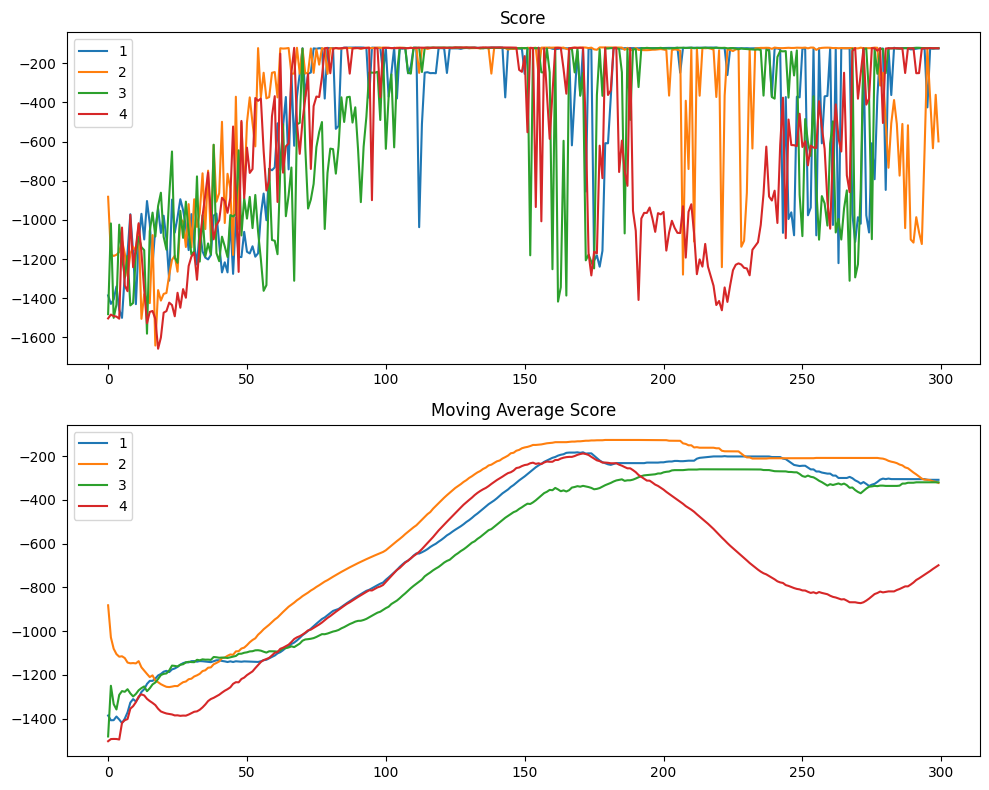

In [30]:

plt.figure(figsize=(10, 8))

plt.subplot(2,1,1)
for i in range(len(Update_Target)):
    sns.lineplot(x=episode_number, y=Update_Target_scores[i], label=Update_Target[i])
plt.title('Score')

# Moving Average Score
plt.subplot(2, 1, 2)
for i in range (len(Update_Target)):
    sns.lineplot(x=episode_number, y=Update_Target_average[i], label=Update_Target[i])
plt.title('Moving Average Score')

plt.tight_layout()
plt.show()

Observation:

We can see that, 1 Update to Target Model/ 2 Epsiodes seems to strike the right balance for how much it lags behind the Main model. It also allows the model to run more smoothly.

### Reward Normalization
Refer to other .ipynb

## Final Model Evaluation & Save

In [15]:
dqn = DQN(InputShape = 3, NActions = 40, Gamma = 0.98, low_penalty= 1.1, low_score_epsilon=0.005, MemorySize=20000, UpdateTargetEveryThisEpisodes=2)
final_score, final_average = RunEpisodes(dqn, EPISODES, save_weights='FinalWeights.h5', load_weights=False)

 
List of Parameters:
Number of Actions: 40,
Gamma: 0.98,
Learning Rate: 0.001,
Memory Size: 20000,
Min Memory: 1000,
Update Target Every This Episodes: 2,
Dense Layers: 64,
Batch Size: 32,
Epsilon: 0.1,
Epsilon Decay: 0.95,
Optimiser: 0.0010000000474974513,
High Penalty: 0.95,
Low Penalty: 1.1,
Low Score Epsilon: 0.005

Model: "Main"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 3)]               0         
                                                                 
 1stHiddenLayer (Dense)      (None, 64)                256       
                                                                 
 2ndHiddenLayer (Dense)      (None, 64)                4160      
                                                                 
 Output (Dense)              (None, 40)                2600      
                                                                 
Tot

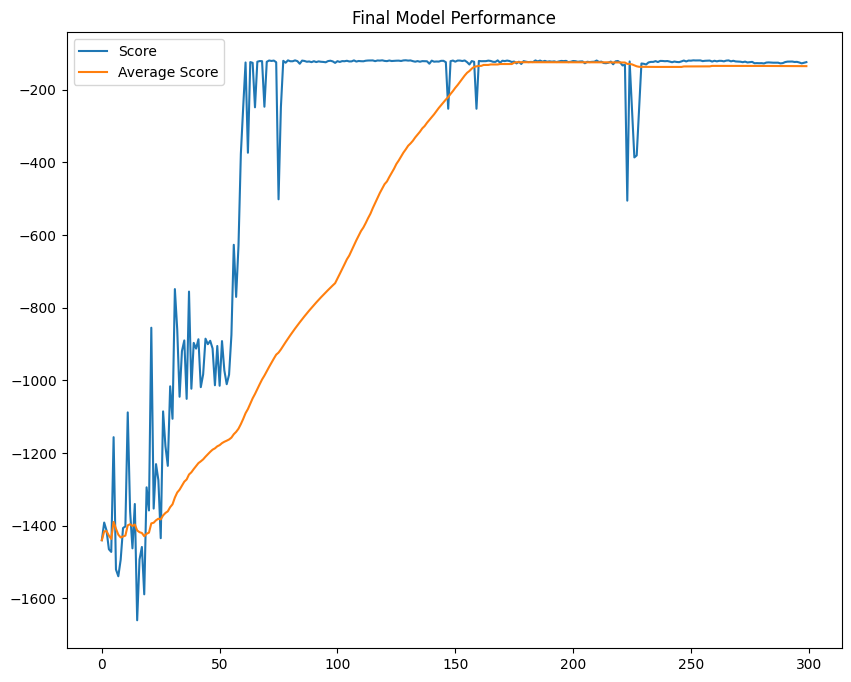

In [16]:
plt.figure(figsize=(10, 8))

sns.lineplot(x=episode_number, y=final_score, label="Score")
sns.lineplot(x=episode_number, y=final_average, label="Average Score")

plt.title('Final Model Performance')
plt.show()

### Loading of Any Model

Must run the cells in Build Model

 
List of Parameters:
Number of Actions: 40,
Gamma: 0.98,
Learning Rate: 0.001,
Memory Size: 20000,
Min Memory: 1000,
Update Target Every This Episodes: 2,
Dense Layers: 64,
Batch Size: 32,
Epsilon: 0.1,
Epsilon Decay: 0.95,
Optimiser: 0.0010000000474974513,
High Penalty: 0.95,
Low Penalty: 1.1,
Low Score Epsilon: 0.005

Model: "Main"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 3)]               0         
                                                                 
 1stHiddenLayer (Dense)      (None, 64)                256       
                                                                 
 2ndHiddenLayer (Dense)      (None, 64)                4160      
                                                                 
 Output (Dense)              (None, 40)                2600      
                                                                 
Tot

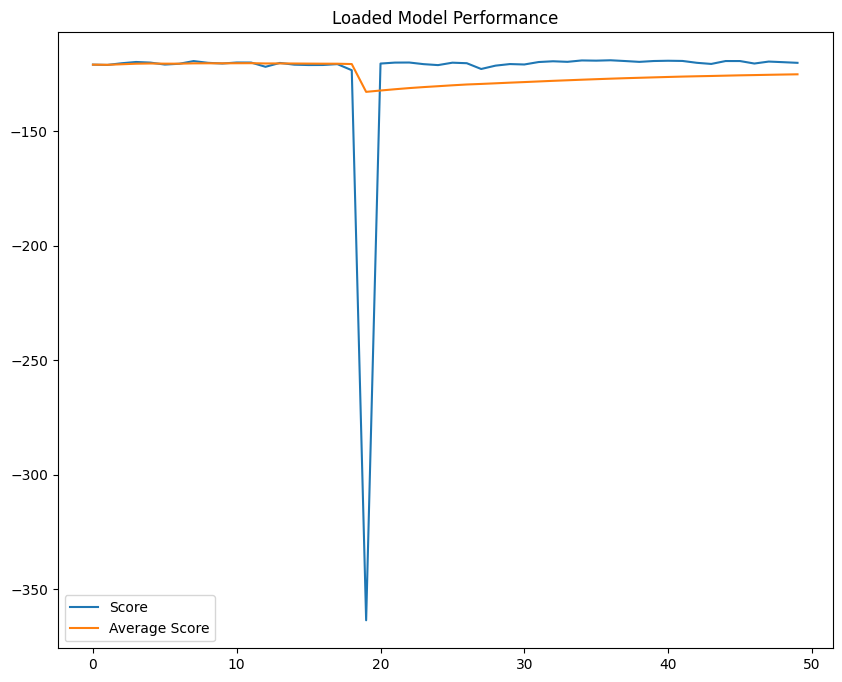

In [10]:
weights = 'DQN_Weights/MainPendulum_FinalWeights.h5'
dqn = DQN(InputShape = 3, load_weights = weights, NActions = 40, Gamma = 0.98, low_penalty= 1.1, low_score_epsilon=0.005, MemorySize=20000, UpdateTargetEveryThisEpisodes=2)
loaded_scores, loaded_average = RunEpisodes(dqn, 50, load_weights=True)
episode_number = np.arange(50)

plt.figure(figsize=(10, 8))

sns.lineplot(x=episode_number, y=loaded_scores, label="Score")
sns.lineplot(x=episode_number, y=loaded_average, label="Average Score")

plt.title('Loaded Model Performance')
plt.show()

#### Loaded it without any replay_memory

 
List of Parameters:
Number of Actions: 40,
Gamma: 0.98,
Learning Rate: 0.001,
Memory Size: 20000,
Min Memory: 1000,
Update Target Every This Episodes: 2,
Dense Layers: 64,
Batch Size: 32,
Epsilon: 0.1,
Epsilon Decay: 0.95,
Optimiser: 0.0010000000474974513,
High Penalty: 0.95,
Low Penalty: 1.1,
Low Score Epsilon: 0.005

Model: "Main"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 3)]               0         
                                                                 
 1stHiddenLayer (Dense)      (None, 64)                256       
                                                                 
 2ndHiddenLayer (Dense)      (None, 64)                4160      
                                                                 
 Output (Dense)              (None, 40)                2600      
                                                                 
Tot

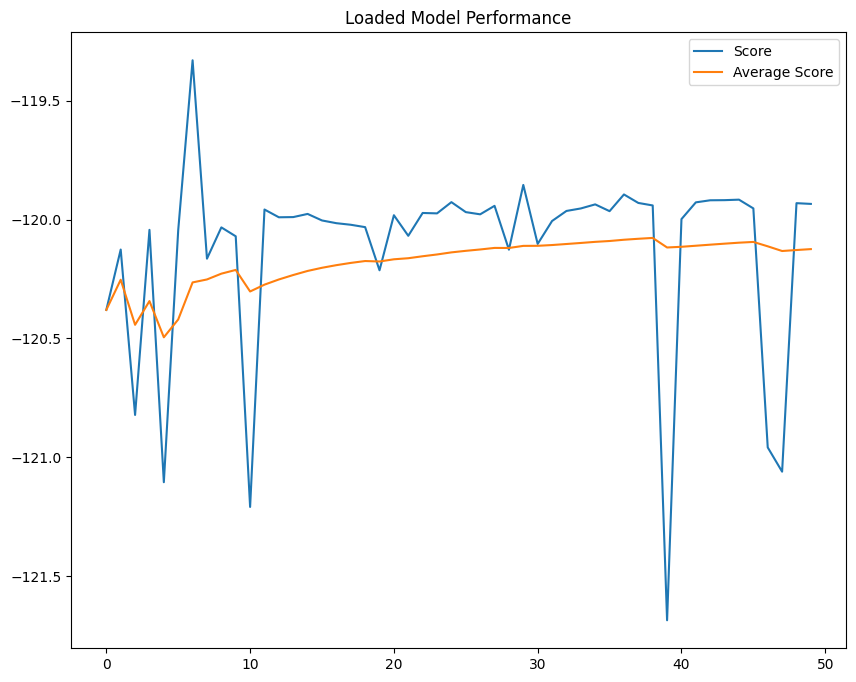

In [26]:
weights = 'DQN_Weights/MainPendulum_FinalWeights.h5'
dqn = DQN(InputShape = 3, load_weights = weights, NActions = 40, Gamma = 0.98, low_penalty= 1.1, low_score_epsilon=0.005, MemorySize=20000, UpdateTargetEveryThisEpisodes=2)
loaded_scores, loaded_average = RunEpisodes(dqn, 50, load_weights=True, replay_memory = False)
episode_number = np.arange(50)

plt.figure(figsize=(10, 8))

sns.lineplot(x=episode_number, y=loaded_scores, label="Score")
sns.lineplot(x=episode_number, y=loaded_average, label="Average Score")

plt.title('Loaded Model Performance')
plt.show()

# An Alternative Solution (DDPG)

Dependencies for training:<br>
- create a ddpg folder within a tmp folder to store weights

In [11]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf 
from tensorflow.keras import layers 
from tensorflow.keras.optimizers import Adam

In [12]:
class ReplayBuffer:
    def __init__(self, max_size, input_shape, n_actions):
        self.memory_size = max_size
        self.memory_center = 0
        self.state_memory = np.zeros((self.memory_size, *input_shape))
        self.new_state_memory = np.zeros((self.memory_size, *input_shape))
        self.action_memory = np.zeros((self.memory_size, n_actions))
        self.reward_memory = np.zeros(self.memory_size)
        self.terminal_memory = np.zeros(self.memory_size, dtype=bool)

    def store_transition(self, state, action, reward, new_state, done):
        index = self.memory_center % self.memory_size

        self.state_memory[index] = state
        self.new_state_memory[index] = new_state
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = done

        self.memory_center += 1

    def sample_buffer(self, batch_size):
        max_memory = min(self.memory_center, self.memory_size)

        batch = np.random.choice(max_memory, batch_size, replace=False)

        states = self.state_memory[batch]
        states_ = self.new_state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        dones = self.terminal_memory[batch]

        return states, actions, rewards, states_, dones

In [13]:

class CriticNetwork(tf.keras.Model):
    def __init__(self, fc1_dims=512, fc2_dims=512,
                name='critic', chkpt_dir='tmp/ddpg'):
        super(CriticNetwork, self).__init__()
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims

        self.model_name = name
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, 
                                            self.model_name+'_ddpg.h5')

        self.fc1 = layers.Dense(self.fc1_dims, activation='relu')
        self.fc2 = layers.Dense(self.fc2_dims, activation='relu')
        self.q = layers.Dense(1, activation=None) # q value, no activation as we want linearity

    def call(self, state, action):
        action_value = self.fc1(tf.concat([state, action], axis=1))
        action_value = self.fc2(action_value)

        # calculate q value
        q = self.q(action_value)

        return q

class ActorNetwork(tf.keras.Model):
    def __init__(self, fc1_dims=512, fc2_dims=512, n_actions=2, 
                name='actor', chkpt_dir='tmp/ddpg'):
        super(ActorNetwork, self).__init__()
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions # how many moves actor network has

        self.model_name = name
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, 
                                            self.model_name+'_ddpg.h5')

        self.fc1 = layers.Dense(self.fc1_dims, activation='relu')
        self.fc2 = layers.Dense(self.fc2_dims, activation='relu')
        self.mu = layers.Dense(self.n_actions, activation='tanh') # tanh as we want multiples of +-2

    def call(self, state):
        probability = self.fc1(state)
        probability = self.fc2(probability)
        mu = self.mu(probability)

        return mu

In [14]:
class Agent:
    def __init__(self, input_dims, alpha=0.001, beta=0.002, env=None,
                 gamma=0.99, n_actions=2, max_size=1000000, tau=0.005,
                 fc1=400, fc2=300, batch_size=64, noise=0.1):
        
        self.gamma = gamma
        self.tau = tau
        self.memory = ReplayBuffer(max_size, input_dims, n_actions)
        self.batch_size = batch_size
        self.n_actions = n_actions
        self.noise = noise
        self.max_action = env.action_space.high[0]
        self.min_action = env.action_space.low[0]

        self.actor = ActorNetwork(n_actions=n_actions, 
                                  name='actor')
        self.critic = CriticNetwork(name='critic')

        self.target_actor = ActorNetwork(n_actions=n_actions,
                                         name='target_actor')
        self.target_critic = CriticNetwork(name='target_critic')

        self.actor.compile(optimizer=Adam(learning_rate=alpha))
        self.critic.compile(optimizer=Adam(learning_rate=beta))
        
        self.target_actor.compile(optimizer=Adam(learning_rate=alpha))
        self.target_critic.compile(optimizer=Adam(learning_rate=beta))

        self.update_network_parameters(tau=1)

    def update_network_parameters(self, tau=None):
        if tau is None:
            tau = self.tau

        weights = []
        targets = self.target_actor.weights
        for i, weight in enumerate(self.actor.weights):
            weights.append(weight * tau + targets[i]*(1-tau))
        self.target_actor.set_weights(weights)

        weights = []
        targets = self.target_critic.weights
        for i, weight in enumerate(self.critic.weights):
            weights.append(weight * tau + targets[i]*(1-tau))
        self.target_critic.set_weights(weights)

    def remember(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)

    def save_models(self):
        print('... saving models ...')
        self.actor.save_weights(self.actor.checkpoint_file)
        self.target_actor.save_weights(self.target_actor.checkpoint_file)

        self.critic.save_weights(self.critic.checkpoint_file)
        self.target_critic.save_weights(self.target_critic.checkpoint_file)

    def load_models(self):
        print('... loading models ...')
        self.actor.load_weights(self.actor.checkpoint_file)
        self.target_actor.load_weights(self.target_actor.checkpoint_file)

        self.critic.load_weights(self.critic.checkpoint_file)
        self.target_critic.load_weights(self.target_critic.checkpoint_file)

    def choose_action(self, observation, evaluate=False):
        state = tf.convert_to_tensor([observation], dtype=tf.float32)
        actions = self.actor(state)
        if not evaluate:
            actions += tf.random.normal(shape=[self.n_actions],
                                        mean=0.0, stddev=self.noise)
        # note that if the env has an action > 1, we have to multiply by
        # max action at some point
        actions = tf.clip_by_value(actions, self.min_action, self.max_action)

        return actions[0]

    def learn(self):
        if self.memory.memory_center < self.batch_size:
            return

        # sample from memory
        state, action, reward, new_state, done = self.memory.sample_buffer(self.batch_size)

        states = tf.convert_to_tensor(state, dtype=tf.float32)
        states_ = tf.convert_to_tensor(new_state, dtype=tf.float32)
        rewards = tf.convert_to_tensor(reward, dtype=tf.float32)
        actions = tf.convert_to_tensor(action, dtype=tf.float32)

        with tf.GradientTape() as tape:
            # calculate critic network loss
            target_actions = self.target_actor(states_)

            # squeeze as we have a batch dim
            critic_value_ = tf.squeeze(self.target_critic(states_, target_actions), 1)
            critic_value = tf.squeeze(self.critic(states, actions), 1)

            target = rewards + self.gamma*critic_value_*(1-done)
            critic_loss = tf.keras.losses.MSE(target, critic_value)

        critic_network_gradient = tape.gradient(critic_loss,
                                                self.critic.trainable_variables)
         
        self.critic.optimizer.apply_gradients(zip(
            critic_network_gradient, self.critic.trainable_variables))

        with tf.GradientTape() as tape:
            # calculate actor network loss
            new_policy_actions = self.actor(states) # actions according to actor based on current set of weights
            actor_loss = -self.critic(states, new_policy_actions)
            actor_loss = tf.math.reduce_mean(actor_loss)

        # gradient of critic loss with respect to mu parameters
        actor_network_gradient = tape.gradient(actor_loss,
                                               self.actor.trainable_variables)
        
        self.actor.optimizer.apply_gradients(zip(
            actor_network_gradient, self.actor.trainable_variables))

        self.update_network_parameters()

episode  0 score -1014.0 avg score -1014.0
episode  1 score -1737.0 avg score -1375.5
episode  2 score -1420.3 avg score -1390.4
episode  3 score -1615.3 avg score -1446.7
episode  4 score -1632.0 avg score -1483.7
episode  5 score -1459.6 avg score -1479.7
episode  6 score -1491.5 avg score -1481.4
episode  7 score -1304.9 avg score -1459.3
episode  8 score -1309.5 avg score -1442.7
episode  9 score -1744.9 avg score -1472.9
episode  10 score -1249.3 avg score -1452.6
episode  11 score -1006.9 avg score -1415.4
episode  12 score -1713.6 avg score -1438.4
episode  13 score -1122.8 avg score -1415.8
episode  14 score -795.0 avg score -1374.4
episode  15 score -860.2 avg score -1342.3
episode  16 score -1153.3 avg score -1331.2
episode  17 score -1110.0 avg score -1318.9
episode  18 score -1115.7 avg score -1308.2
episode  19 score -955.5 avg score -1290.6
episode  20 score -1155.5 avg score -1284.1
episode  21 score -865.6 avg score -1265.1
episode  22 score -912.6 avg score -1249.8
epi

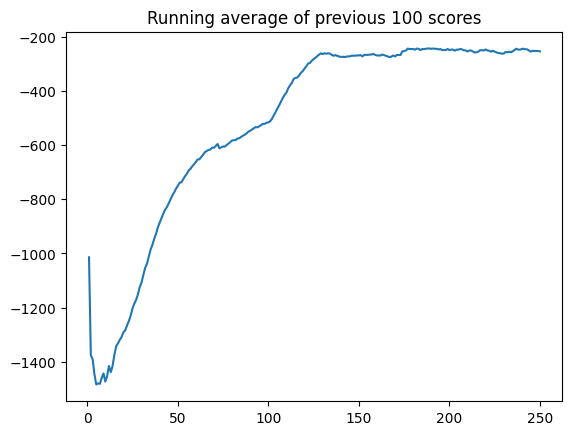

In [19]:

# helper function
def plot_learning_curve(x, scores, figure_file):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
    plt.plot(x, running_avg)
    plt.title('Running average of previous 100 scores')
    plt.savefig(figure_file)


env = gym.make('Pendulum-v0')
env.seed(42)
agent = Agent(input_dims=env.observation_space.shape, env=env,
            n_actions=env.action_space.shape[0])
episodes = 250

figure_file = 'pendulum.png'

best_score = env.reward_range[0] # lower bound of reward range
score_history = []
load_checkpoint = False

if load_checkpoint:
    n_steps = 0
    while n_steps <= agent.batch_size:
        # note: observation = state
        observation = env.reset()
        action = env.action_space.sample()
        new_observation, reward, done, info = env.step(action)
        agent.remember(observation, action, reward, new_observation, done)
        n_steps += 1
    agent.learn()
    agent.load_models()
    evaluate = True
else:
    evaluate = False

for i in range(episodes):
    observation = env.reset()
    done = False
    score = 0
    while not done:
        action = agent.choose_action(observation, evaluate)
        new_observation, reward, done, info = env.step(action)
        score += reward
        agent.remember(observation, action, reward, new_observation, done)
        if not load_checkpoint:
            agent.learn()
        observation = new_observation

    score_history.append(score)
    avg_score = np.mean(score_history[-100:])

    if avg_score > best_score:
        best_score = avg_score
        # if not load_checkpoint:
            # agent.save_models()
    print('episode ', i, 'score %.1f' % score, 'avg score %.1f' % avg_score)

if not load_checkpoint:
    x = [i+1 for i in range(episodes)]
    plot_learning_curve(x, score_history, figure_file)